# Coursework Assignment: Building a Regression Model

```
University of London
BSc in Computer Science
CM3005, Data Science
Hudson Leonardo MENDES
hlm12@student.london.ac.uk
```


# I. Introduction


## Domain-specific area


## Dataset


## Objectives


# II. Implementation


## Preprocessing


In [ ]:
import pathlib

data_folderpath = pathlib.Path("./data")

ppd_folderpath = data_folderpath / "uk-ppd"
inflation_filepath = data_folderpath / "uk-ons/ons-inflation-1989-2022.csv"
interest_filepath = data_folderpath / "uk-boe/boe-interest-1975-2022.csv"


In [ ]:
import pandas as pd

pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))


In [ ]:
# https://www.gov.uk/guidance/about-the-price-paid-data
ppd_property_type = {
    "D": "detached",
    "S": "semi-detached",
    "T": "terraced",
    "F": "flat/maisonettes",
    # "O": "other" # => intentionally ommitted
}

ppd_duration = {"F": "freehold", "L": "leasehold"}

ppd_old_or_new = {"Y": "new", "N": "old"}

ppd_df = pd.concat(
    [
        pd.read_csv(
            ppd_filepath,
            compression="zip",
            names=[
                "id",
                "price",
                "date",
                "postcode",
                "property_type",
                "old_or_new",
                "duration",
                "paon",
                "saon",
                "street",
                "locality",
                "town_city",
                "district",
                "county",
                "ppd_category_type",
                "record_status",
            ],
        )
        for ppd_filepath in ppd_folderpath.glob("*.zip")
    ]
)
ppd_df["postgroup"] = ppd_df["postcode"].map(lambda x: str(x).split(" ")[0])
ppd_df["date"] = pd.to_datetime(ppd_df["date"])
ppd_df["property_type"] = ppd_df["property_type"].map(ppd_property_type.get)
ppd_df["duration"] = ppd_df["duration"].map(ppd_duration.get)
ppd_df["old_or_new"] = ppd_df["old_or_new"].map(ppd_old_or_new.get)
ppd_df = ppd_df[
    [
        "date",
        "postgroup",
        "property_type",
        "old_or_new",
        "duration",
        "price",
    ]
]
ppd_df = ppd_df.astype(
    {
        "postgroup": "category",
        "property_type": "category",
        "old_or_new": "category",
        "duration": "category",
        "price": "double",
    }
)
ppd_df = ppd_df.dropna()
ppd_df.sample(n=5)


In [ ]:
import re
import string
from datetime import date

inflation_date_pattern = re.compile(r"([\d]{4})(?:\s+([\w]{3}))?")
inflation_month_names = [
    "JAN",
    "FEB",
    "MAR",
    "APR",
    "MAY",
    "JUN",
    "JUL",
    "AUG",
    "SEP",
    "OCT",
    "NOV",
    "DEC",
]
inflation_month_index = {mn: ix + 1 for (ix, mn) in enumerate(inflation_month_names)}
inflation_month_index["Q1"] = 1
inflation_month_index["Q2"] = 4
inflation_month_index["Q3"] = 7
inflation_month_index["Q3"] = 10

inflation_acceptable_numeric_chars = string.digits + ".,"


def extract_inflation_date(x: str) -> date:
    match = next(inflation_date_pattern.finditer(x), None)
    if match:
        group_count = len(match.groups())
        if group_count >= 1:
            year = int(match.group(1))
            month = 1
            month_name = match.group(2)
            if group_count > 1 and month_name:
                month_name = month_name.strip().upper()
                month = inflation_month_index.get(month_name)
            return date(year, month, 1)


def extract_inflation_rate(x: str) -> float:
    x = str(x)
    if all([c in inflation_acceptable_numeric_chars for c in x]):
        return float(x)
    return None


inflation_df = pd.read_csv(inflation_filepath)
inflation_df["date"] = inflation_df["Title"].map(extract_inflation_date)
inflation_df["date"] = pd.to_datetime(inflation_df["date"])
inflation_df["rate"] = inflation_df["CPIH ANNUAL RATE 00: ALL ITEMS 2015=100"].map(extract_inflation_rate)
inflation_df["rate"] = inflation_df["rate"].astype("float", errors="ignore")
inflation_df = inflation_df[["date", "rate"]]
inflation_df = inflation_df.dropna()
inflation_df = inflation_df.set_index("date").sort_index()
inflation_df.sample(n=5)


In [ ]:
interest_df = pd.read_csv(interest_filepath)
interest_df["date"] = pd.to_datetime(interest_df["Date Changed"])
interest_df["rate"] = interest_df["Rate"].astype("float")
interest_df = interest_df[["date", "rate"]]
interest_df = interest_df.set_index("date").sort_index()
interest_df.sample(n=5)


In [ ]:
from tqdm import tqdm, trange
from typing import Callable
from datetime import date, timedelta

tqdm.pandas()


def build_rate_extractor(df: pd.DataFrame) -> Callable[[date], float]:
    min_date = df.index.min()
    max_date = df.index.max()
    cur_date = min_date
    rate_index = {}
    first_rate = df.rate[0]
    prev_rate = first_rate
    last_rate = df.rate[-1]
    with trange((max_date - min_date).days, desc="rate_index") as pbar:
        while cur_date <= max_date:
            rates = df[df.index == cur_date].rate
            if rates.any():
                new_rate = rates[0] / 100.0
                rate_index[cur_date] = new_rate
                prev_rate = new_rate
            else:
                rate_index[cur_date] = prev_rate
            cur_date += timedelta(days=1)
            pbar.update()

    def get_rate_for_date(d: date) -> float:
        if d < min_date:
            return first_rate
        elif d > max_date:
            return last_rate
        else:
            return rate_index[d]

    return get_rate_for_date


df = ppd_df.copy()
df["inflation_rate"] = df.date.progress_map(build_rate_extractor(df=inflation_df))
df["interest_rate"] = df.date.progress_map(build_rate_extractor(df=interest_df))
df["date_year"] = df.date.progress_map(lambda d: d.year)
df["date_month"] = df.date.progress_map(lambda d: d.month)
df["date_day"] = df.date.progress_map(lambda d: d.day)
df["date_day_of_week"] = df.date.progress_map(lambda d: d.weekday())
df = df.sort_values(by="date").reset_index()
df = df[
    ["date_year", "date_month", "date_day", "date_day_of_week"]
    + list(ppd_df.columns[1:-1])
    + ["inflation_rate", "interest_rate", "price"]
]
df.sample(n=5)


In [ ]:
df.info()


In [ ]:
df.to_csv(data_folderpath / "snapshot-Xy-1NF.zip", index=False)


## Statistical Summary


In [ ]:
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd
    import numpy as np

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {
            "postgroup": "category",
            "property_type": "category",
            "old_or_new": "category",
            "duration": "category",
            "price": "double",
        }
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


In [ ]:
df_feats_continuous = df.select_dtypes(include="float")
df_feats_continuous.sample(n=5)


### Central Tendency


In [ ]:
df_central_tendency = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.mean(), columns=["mean"]).transpose(),
        pd.DataFrame(df_feats_continuous.median(), columns=["median"]).transpose(),
        pd.DataFrame([df_feats_continuous[c].mode()[0] for c in df_feats_continuous.columns], columns=["mode"])
        .set_index(df_feats_continuous.columns)
        .transpose(),
    ]
)

df_central_tendency


### Measures of Spread


In [ ]:
df_measures_of_spread = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.var(), columns=["var"]).transpose(),
        df_feats_continuous.describe(),
        pd.DataFrame(
            df_feats_continuous.quantile(0.75) - df_feats_continuous.quantile(0.25), columns=["IQR"]
        ).transpose(),
    ]
)


df_measures_of_spread


### Type of Distribution


In [ ]:
df_types_of_distros = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.skew(), columns=["skew"]).transpose(),
        pd.DataFrame(df_feats_continuous.kurtosis(), columns=["kurtosis"]).transpose(),
    ]
)

df_types_of_distros


## Data visualisation


In [1]:
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {
            "postgroup": "category",
            "property_type": "category",
            "old_or_new": "category",
            "duration": "category",
            "price": "double",
        }
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


[SNAPSHOT] Reloading...
 - reloaded from snapshot, 4336841


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
3615180,2021,9,30,3,B23,terraced,old,freehold,0.029,0.001,"204,000.000"
3166095,2021,5,20,3,LE16,flat/maisonettes,old,leasehold,0.021,0.001,"136,500.000"
3959417,2022,3,11,4,NG5,detached,old,freehold,0.062,0.005,"190,000.000"
1605934,2019,9,17,1,LN13,semi-detached,old,freehold,0.017,0.007,"120,000.000"
717166,2018,10,5,4,S40,detached,old,freehold,0.022,0.007,"265,000.000"


In [2]:
df_feats_continuous = df.select_dtypes(include="float")
df_feats_continuous.sample(n=5)


,inflation_rate,interest_rate,price
30378,0.027,0.005,"445,000.000"
697670,0.022,0.007,"192,500.000"
1576769,0.017,0.007,"420,000.000"
2936464,0.010,0.001,"575,000.000"
776153,0.022,0.007,"1,175,000.000"


In [3]:
%matplotlib inline

In [4]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter


### Comparison of Continuous Attributes


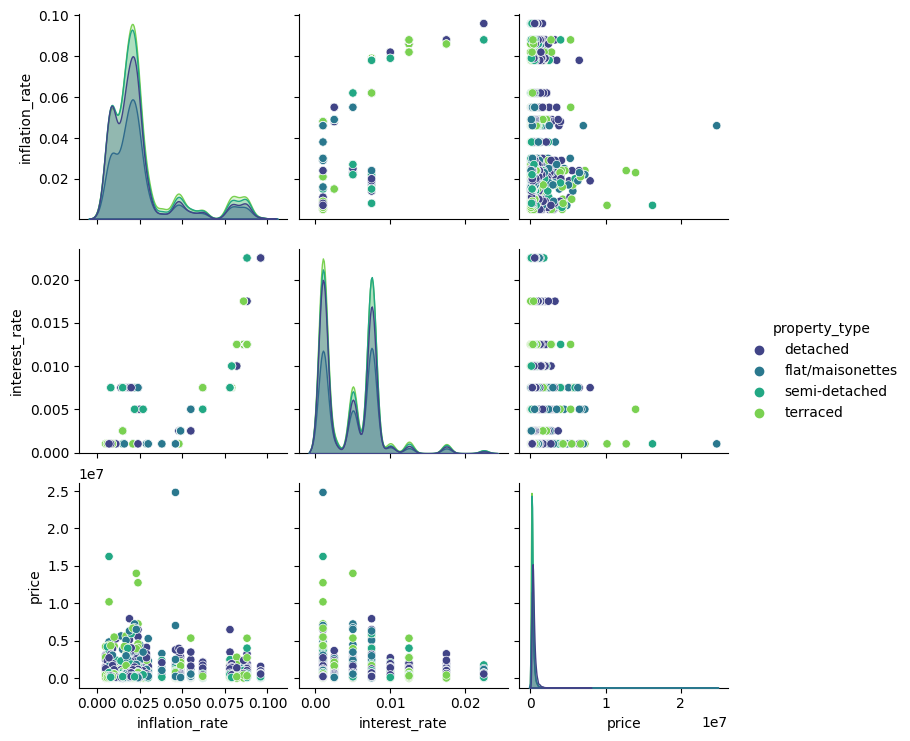

In [5]:
from scipy.stats import pearsonr


df_feats_scaled_continuous_with_ptype = df[list(df_feats_continuous.columns) + ["property_type"]]
sns.pairplot(
    data=df_feats_scaled_continuous_with_ptype.sample(n=int(df_feats_scaled_continuous_with_ptype.shape[0] * 0.01)),
    hue="property_type",
    kind="scatter",
    diag_kind="kde",
    palette="viridis",
)


### Distributions for Inflation Rate & Interest Rate


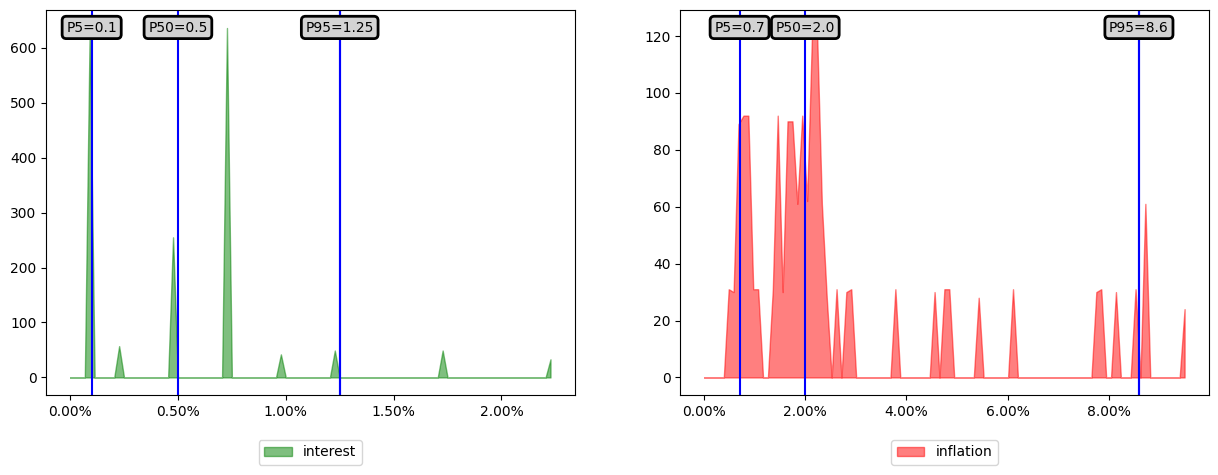

In [6]:
def plot_rate_distributions(ax, df: pd.DataFrame, label: str, color: str):
    df = df.copy()
    df["rate"] = df["rate"] * 100.0
    x = np.linspace(0.0, df["rate"].max(), 100)
    df["bin"] = pd.cut(df["rate"], bins=x)
    y = list(df.groupby("bin").count()["rate"])
    ax.fill_between(x[:-1], 0.0, y, color=color, alpha=0.5)
    ax.xaxis.set_major_formatter(FormatStrFormatter("%2.2f%%"))
    intervals = [0.05, 0.5, 0.95]
    for interval, quantile in zip(intervals, df.rate.quantile(intervals)):
        percentile = f"P{int(interval*100.)}={round(quantile, 2)}"
        bbox = dict(boxstyle="round, pad=0.3", fc="lightgray", lw=2)
        ax.axvline(x=quantile, color="blue")
        ax.annotate(
            percentile,
            xy=(quantile, max(y)),
            bbox=bbox,
            ha="center",
            va="center",
        )
    ax.axvline(x=quantile, color="blue")
    ax.legend([label], loc="lower center", bbox_to_anchor=(0.5, -0.2))


df_daily_means = df.groupby(["date_year", "date_month", "date_day"]).mean(numeric_only=True)
df_daily_means_interest = df_daily_means[["interest_rate"]].rename(columns={"interest_rate": "rate"})
df_daily_means_inflation = df_daily_means[["inflation_rate"]].rename(columns={"inflation_rate": "rate"})
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
plot_rate_distributions(
    ax=axes[0],
    df=df_daily_means_interest,
    label="interest",
    color="green",
)
plot_rate_distributions(
    ax=axes[1],
    df=df_daily_means_inflation,
    label="inflation",
    color="red",
)


### Time-Distribution Inflation, Interest & Property Price per Type


100%|██████████| 4/4 [00:00<00:00, 78.70it/s]


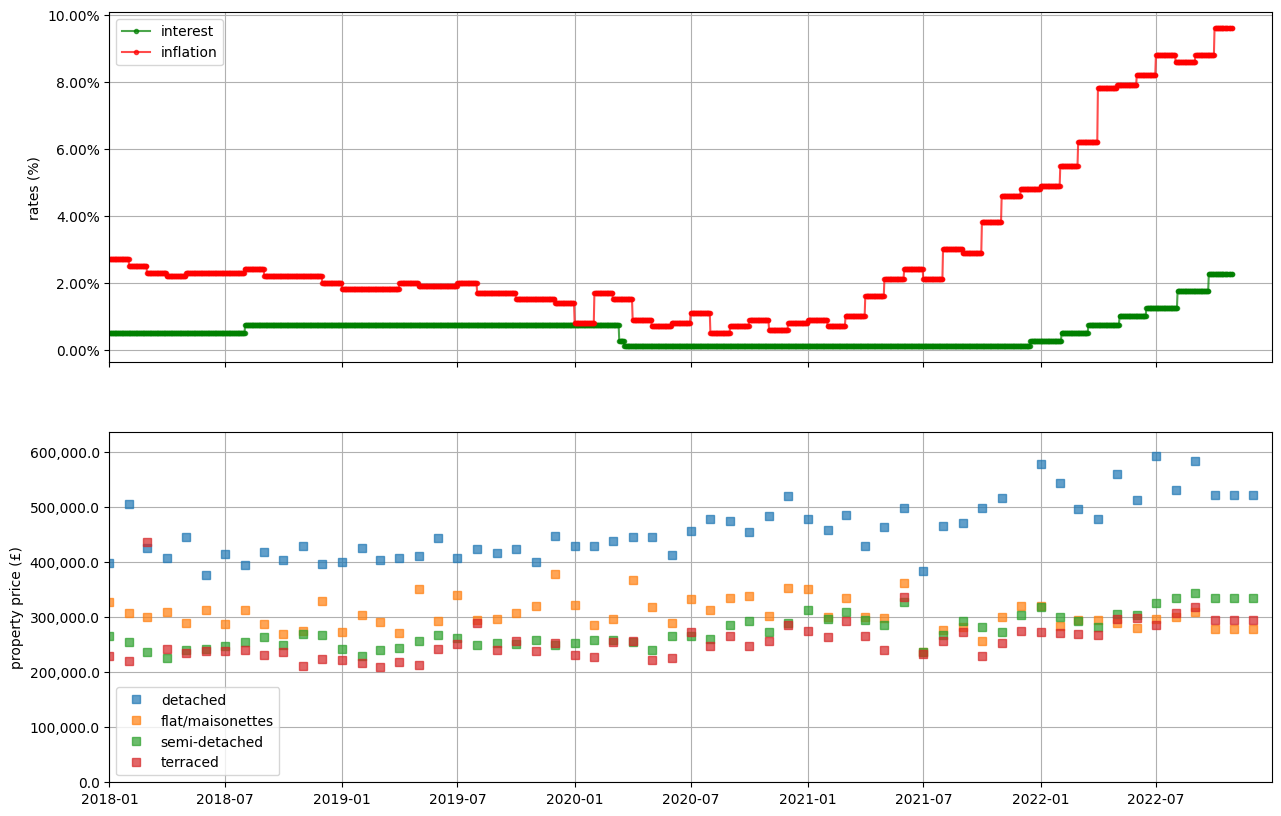

In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import date


def plot_inflation_and_interest(
    ax: plt.Axes,
    df_mean_by_date: pd.DataFrame,
    xlim_left: float,
    xlim_right: float,
):
    df_mean_by_date = df_mean_by_date.reset_index()
    x = df_mean_by_date.apply(lambda r: date(int(r.date_year), int(r.date_month), int(r.date_day)), axis=1)
    ax.grid(visible=True)
    ax.plot(x, df_mean_by_date.interest_rate * 100.0, "g.-", alpha=0.7)
    ax.plot(x, df_mean_by_date.inflation_rate * 100.0, "r.-", alpha=0.7)
    ax.set_xlim(left=xlim_left, right=xlim_right)
    ax.set_ylabel("rates (%)")
    ax.yaxis.set_major_formatter(FormatStrFormatter("%2.2f%%"))
    ax.legend(["interest", "inflation"])


def plot_prices_per_property_type(
    ax: plt.Axes,
    df_mean_by_date_and_pt: pd.DataFrame,
):
    df_mean_by_date_and_pt = df_mean_by_date_and_pt.reset_index()
    ax.grid(visible=True)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,}"))
    ax.set_ylim(0.0, df_mean_by_date_and_pt.price.quantile(0.95) * 1.2)
    ax.set_ylabel("property price (£)")
    property_types = sorted(df_mean_by_date_and_pt.property_type.unique())
    for ix, property_type in tqdm(list(enumerate(property_types))):
        sub_series = df_mean_by_date_and_pt[df_mean_by_date_and_pt.property_type == property_type].copy()
        sub_series = sub_series.reset_index().groupby(["date_year", "date_month"]).mean(numeric_only=True).reset_index()
        sub_series = sub_series.fillna(method="ffill")
        x = sub_series.apply(lambda r: date(int(r.date_year), int(r.date_month), 1), axis=1)
        ax.plot(x, sub_series.price, "s", alpha=0.7)
        ax.legend(property_types)


min_intersecting_date = date(df.date_year.min(), 1, 1)
max_intersecting_date = date(df.date_year.max(), 12, 30)
_, axes = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)
plot_inflation_and_interest(
    ax=axes[0],
    df_mean_by_date=df.groupby(["date_year", "date_month", "date_day"]).mean(numeric_only=True),
    xlim_left=min_intersecting_date,
    xlim_right=max_intersecting_date,
)
plot_prices_per_property_type(
    ax=axes[1],
    df_mean_by_date_and_pt=df.groupby(["date_year", "date_month", "date_day", "property_type"]).mean(numeric_only=True),
)


## Machine learning model


In [9]:
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd
    import numpy as np

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {
            "postgroup": "category",
            "property_type": "category",
            "old_or_new": "category",
            "duration": "category",
            "price": "double",
        }
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
1871202,2019,12,16,0,SO32,detached,old,freehold,0.014,0.007,"900,000.000"
1625413,2019,9,25,2,PL8,detached,old,freehold,0.017,0.007,"365,000.000"
2419266,2020,9,25,4,MK42,flat/maisonettes,old,leasehold,0.007,0.001,"134,500.000"
697791,2018,9,28,4,LE11,detached,new,freehold,0.022,0.007,"399,995.000"
3022484,2021,3,30,1,KT22,semi-detached,old,freehold,0.010,0.001,"950,000.000"


In [10]:
X, y = df[df.columns[:-1]], df[df.columns[-1]]


### Feature Selection & Encoding

In [39]:
(df
    .groupby(["property_type", "inflation_rate", "interest_rate"])[["price"]]
    .quantile([0.8])
    .dropna()
    .rename(columns={"price": "P80"}))

P80
property_type inflation_rate interest_rate                  
detached      0.005          0.001         0.800 564,200.000
              0.006          0.001         0.800 585,000.000
              0.007          0.001         0.800 575,000.000
              0.008          0.001         0.800 560,000.000
                             0.007         0.800 537,500.000
...                                                      ...
terraced      0.086          0.018         0.800 405,000.000
              0.088          0.013         0.800 390,000.000
                             0.018         0.800 408,000.000
                             0.022         0.800 401,000.000
              0.096          0.022         0.800 400,000.000

[192 rows x 1 columns]

In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import make_column_transformer, make_column_selector


def make_sine_cycle_encoder(period: int = 1) -> float:
    assert period != 0
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


# https://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use
def make_df_column_transformer():
    categorical_selector = make_column_selector(dtype_include="category")
    float_seletor = make_column_selector(dtype_include="float64")
    one_hot = OneHotEncoder(sparse_output=True, handle_unknown="ignore")
    numerical_scaler = StandardScaler(with_mean=True, with_std=True)
    cycle_sine_12 = make_sine_cycle_encoder(period=12)
    cycle_sine_31 = make_sine_cycle_encoder(period=31)
    cycle_sine_6 = make_sine_cycle_encoder(period=6)
    return make_column_transformer(
        (one_hot, categorical_selector),
        (numerical_scaler, float_seletor),
        (numerical_scaler, ["date_year"]),
        (cycle_sine_12, ["date_month"]),
        (cycle_sine_31, ["date_day"]),
        (cycle_sine_6, ["date_day_of_week"]),
        remainder="drop",
        verbose=True,
    )


preprocessing_df_column_transformer = make_df_column_transformer()
X_encoded = preprocessing_df_column_transformer.fit_transform(X)
pd.DataFrame.sparse.from_spmatrix(X_encoded)


[ColumnTransformer] . (1 of 6) Processing onehotencoder, total=   5.4s
[ColumnTransformer]  (2 of 6) Processing standardscaler-1, total=   0.2s
[ColumnTransformer]  (3 of 6) Processing standardscaler-2, total=   0.1s
[ColumnTransformer]  (4 of 6) Processing functiontransformer-1, total=   0.1s
[ColumnTransformer]  (5 of 6) Processing functiontransformer-2, total=   0.2s
[ColumnTransformer]  (6 of 6) Processing functiontransformer-3, total=   0.2s


,0,1,2,3,4,5,6,7,8,9,...,2306,2307,2308,2309,2310,2311,2312,2313,2314,2315
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,1.000,0.000,0.089,0.039,-1.361,0.500,0.201,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,1.000,0.000,0.089,0.039,-1.361,0.500,0.201,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,0.000,1.000,0.089,0.039,-1.361,0.500,0.201,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,1.000,0.000,0.089,0.039,-1.361,0.500,0.201,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,1.000,0.000,0.089,0.039,-1.361,0.500,0.201,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336836,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,0.000,1.000,3.504,4.581,1.617,-0.866,-0.938,0.866
4336837,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,1.000,0.000,3.504,4.581,1.617,-0.866,-0.849,0.866
4336838,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,1.000,0.000,3.504,4.581,1.617,-0.866,-0.849,0.866
4336839,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,1.000,0.000,3.504,4.581,1.617,-0.866,-0.571,-0.866


In [ ]:
from typing import Tuple
from sklearn.model_selection import train_test_split


def produce_split_summary(
    X_split: pd.DataFrame, y_split: pd.DataFrame, name: str, total: int
) -> Tuple[str, int, int, str]:
    return (
        name,
        X_split.shape[0],
        y_split.shape[0],
        "{:.1f}%".format(100.0 * X_split.shape[0] / total),
    )


r = 42
train_size = 0.99
X1, X2, y1, y2 = train_test_split(X_encoded, y, train_size=train_size, random_state=r)
pd.DataFrame(
    [
        produce_split_summary(X, y, "full", total=X.shape[0]),
        produce_split_summary(X1, y1, "train", total=X.shape[0]),
        produce_split_summary(X2, y2, "test", total=X.shape[0]),
    ],
    columns=["split", "|X|", "|y|", "%"],
)


In [ ]:
from typing import Tuple
from sklearn.neural_network import MLPRegressor


def make_model(hidden_layer_sizes: Tuple[int, ...], max_iter: int):
    r = 42
    return MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        validation_fraction=0.01,
        random_state=r,
        verbose=True,
        max_iter=max_iter,
    )


model = make_model(hidden_layer_sizes=(2,), max_iter=1)
model.fit(X1, y1)
pd.DataFrame(
    [
        ("train", model.score(X1, y1)),
        ("test", model.score(X2, y2)),
    ],
    columns=["spit", "score"],
)


In [ ]:
import itertools
import numpy as np
from typing import Set, List, Tuple
from sklearn.model_selection import GridSearchCV


grid = GridSearchCV(
    model,
    param_grid={
        "hidden_layer_sizes": [
            (2, 4),
            (3, 4),
            (4, 4),
            (8, 4),
            (16, 4),
        ],
        "max_iter": [10],
    },
    cv=5,
    verbose=3,
)
grid


In [ ]:
grid.fit(X1, y1)
grid.best_params_


In [ ]:
model = make_model(
    hidden_layer_sizes=grid.best_params_["hidden_layer_sizes"],
    max_iter=200,
)
model


In [ ]:
model.fit(X1, y1)


In [ ]:
model.score(X2, y2)


# III. Conclusions


## Performance of results


## Closing remarks/statements
